In [25]:
%rm -r /kaggle/working/Multi_Class_object_detection-3

In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [3]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.1 MB/s eta 0:00:00
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9320 sha256=23322c75ecb744c4ec80235e91066753a717e5d833c7b85b2da653bd729efaca
  Stored in directory: /root/.cache/pip/wheels/d7/3c/72/5300602ba1269ffce8cff5dcf7b525fee756b57455903c37ba
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=e06feff55e79f87ac4efa

In [4]:
TRAIN = True #False then the last trained model will be used for inference

EPOCHS = 150

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="09MBTB6O924F15ZZeI2L")
project = rf.workspace("rustamji-institute-of-technology").project("multi_class_object_detection")
dataset = project.version(3).download("yolov5")

In [5]:
%cd /kaggle/input/multi-class-classification 

/kaggle/input/multi-class-classification


In [6]:
if not os.path.exists('train'):    
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

In [7]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

class_names = ['Animal', 'Cart', 'Debris', 'Dent', 'Graffiti', 'StreetLight', 'streetsign', 'Tree','Water']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [8]:
class_names = ['Animal', 'Cart', 'Debris', 'Dent', 'Graffiti', 'StreetLight', 'streetsign', 'Tree','Water']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [9]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [10]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [11]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

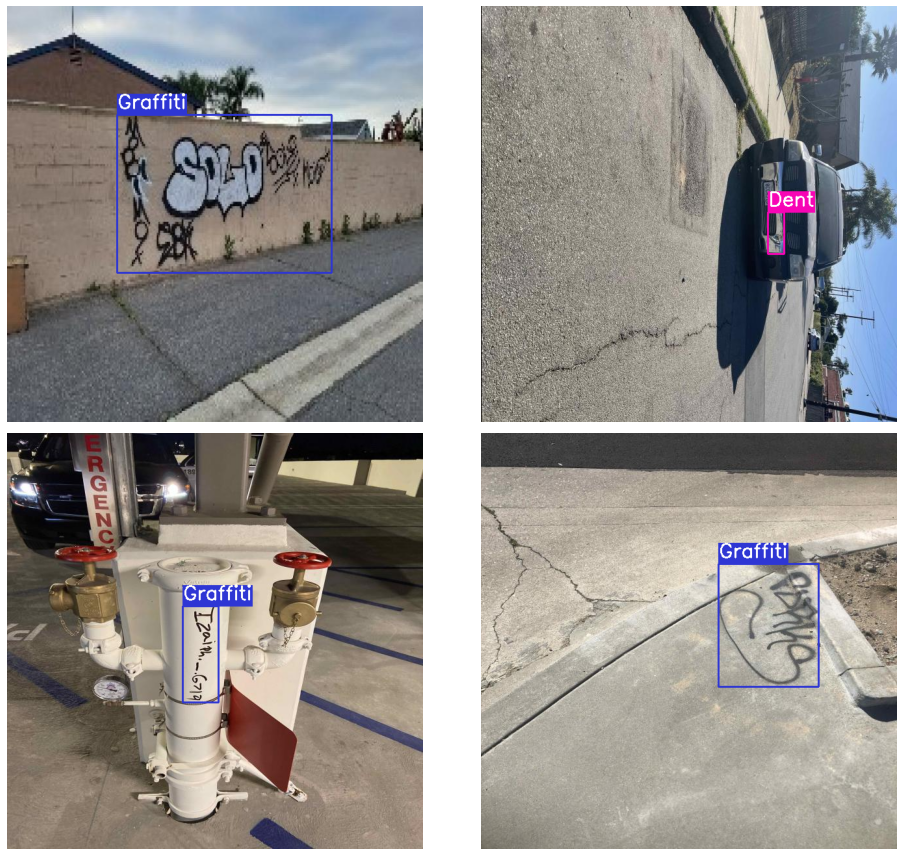

In [12]:
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

In [13]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [14]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

In [15]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [16]:
!ls

CITATION.cff	 __pycache__	export.py	  segment    tutorial.ipynb
CONTRIBUTING.md  benchmarks.py	hubconf.py	  setup.cfg  utils
LICENSE		 classify	models		  state.db   val.py
README.md	 data		requirements.txt  train      valid
README.zh-CN.md  detect.py	runs		  train.py   yolov5s.pt


In [30]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 14432, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 14432 (delta 35), reused 41 (delta 25), pack-reused 14371
Receiving objects: 100% (14432/14432), 13.62 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (9936/9936), done.


In [16]:
%cd /kaggle/working/yolov5
!ls

/kaggle/working/yolov5
CITATION.cff	 __pycache__	export.py	  segment    tutorial.ipynb
CONTRIBUTING.md  benchmarks.py	hubconf.py	  setup.cfg  utils
LICENSE		 classify	models		  state.db   val.py
README.md	 data		requirements.txt  train      valid
README.zh-CN.md  detect.py	runs		  train.py   yolov5s.pt


In [17]:
!pip install -r requirements.txt

In [20]:
#%reload_ext tensorboard
!kill 605

/bin/bash: line 0: kill: (605) - No such process


In [19]:
monitor_tensorboard()
#%reload_ext tensorboard

In [26]:
!pwd

/kaggle/input/yolo-model/yolov5


In [ ]:
import yaml
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data /kaggle/input/multi-class-classification/data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

Current number of result directories: 4
results_5
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/input/multi-class-classification/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% 

In [34]:
#%cp -r /kaggle/input/multi-class-classification/train /kaggle/working/yolov5

In [30]:
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [2]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [44]:
#%cd runs
#%cd train
%cd results_2

[Errno 2] No such file or directory: 'results_2'
/kaggle/working/yolov5


In [29]:
#%cp -r /kaggle/working/yolov5/runs/train/results_2 /kaggle/input/multi-class-classification

In [32]:
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [33]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [39]:
%cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [37]:
!ls

train


In [40]:
 !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}

detect: weights=['runs/train/{RES_DIR}/weights/best.pt'], source={data_path}, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name={INFER_DIR}, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-30-g342fe05 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Traceback (most recent call last):
  File "detect.py", line 261, in <module>
    main(opt)
  File "detect.py", line 256, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 98, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
  File "/kaggl

In [19]:
%cd /kaggle/working/yolov5/runs


/kaggle/working/yolov5/runs


In [26]:
!ls


detect	train


In [25]:
%cd ..


/kaggle/working/yolov5/runs


In [27]:
%cp -r /kaggle/working/yolov5/runs /kaggle/input/multi-class-classification

cp: cannot create directory '/kaggle/input/multi-class-classification/runs': Read-only file system
